# 🧪 EDA of DDInter Dataset

For the **DrugX** project, we are using the [DDInter drug–drug interaction database](https://ddinter.scbdd.com/) as part of our workflow to build the app.
Before processing and using this data, we need to **understand it first**.

That means:

* 👀 Visualizing the dataset
* 🔍 Checking for missing values
* 🔁 Identifying duplicates
* 📊 Exploring the structure and quality

In short: understanding the data is the first step before doing anything else.

💻 No GPU required.

▶️ To run this notebook: `make nb`

At the end, a **summary of findings** is delivered to guide the next steps.

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the CSV
df = pd.read_csv("../ddinter_all.csv")

# Show the first few rows
df.head()

,DDInterID_A,Drug_A,DDInterID_B,Drug_B,Level,category
0,DDInter1263,Naltrexone,DDInter1,Abacavir,Moderate,A
1,DDInter1,Abacavir,DDInter1348,Orlistat,Moderate,A
2,DDInter58,Aluminum hydroxide,DDInter582,Dolutegravir,Major,A
3,DDInter112,Aprepitant,DDInter582,Dolutegravir,Minor,A
4,DDInter138,Attapulgite,DDInter582,Dolutegravir,Major,A


In [3]:
df.shape

(222383, 6)

In [4]:
df.isna().sum(), df.eq("").sum()

(DDInterID_A    0
 Drug_A         0
 DDInterID_B    0
 Drug_B         0
 Level          0
 category       0
 dtype: int64,
 DDInterID_A    0
 Drug_A         0
 DDInterID_B    0
 Drug_B         0
 Level          0
 category       0
 dtype: int64)

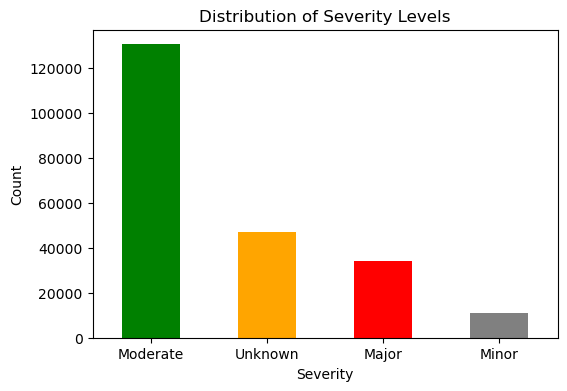

Level
Moderate    130367
Unknown      47182
Major        33896
Minor        10938
Name: count, dtype: int64


In [5]:
# Count severity distribution
severity_counts = df["Level"].value_counts()

# Plot
plt.figure(figsize=(6, 4))
severity_counts.plot(kind="bar", color=["green", "orange", "red", "gray"])
plt.title("Distribution of Severity Levels")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

print(severity_counts)

In [6]:
# 7) Map category code → ATC section (A, B, D, H, L, P, R, V)
CAT_MAP = {
    "A": "Alimentary tract & metabolism",
    "B": "Blood & blood forming organs",
    "D": "Dermatologicals",
    "H": "Systemic hormonal preps (excl. sex hormones & insulins)",
    "L": "Antineoplastic & immunomodulating agents",
    "P": "Antiparasitic products, insecticides & repellents",
    "R": "Respiratory system",
    "V": "Various",
}
df["category_desc"] = df["category"].map(CAT_MAP).fillna("Unknown")
df["category_desc"].value_counts()

category_desc
Antineoplastic & immunomodulating agents                   65389
Alimentary tract & metabolism                              56367
Respiratory system                                         30563
Dermatologicals                                            25681
Blood & blood forming organs                               15140
Various                                                    12024
Systemic hormonal preps (excl. sex hormones & insulins)    11727
Antiparasitic products, insecticides & repellents           5492
Name: count, dtype: int64

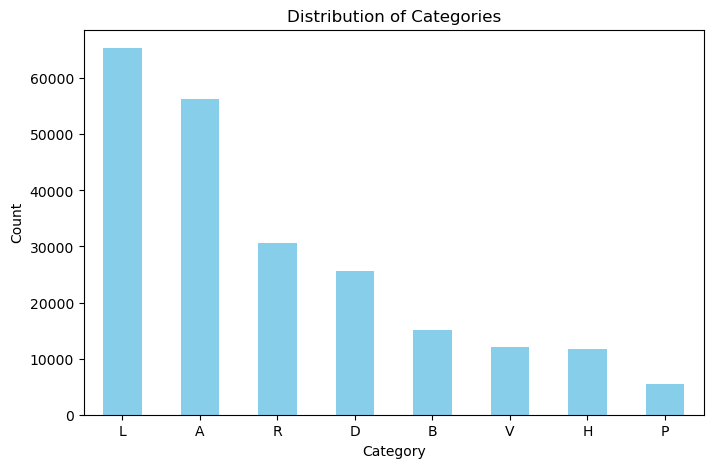

category
L    65389
A    56367
R    30563
D    25681
B    15140
V    12024
H    11727
P     5492
Name: count, dtype: int64


In [7]:
# Count category distribution
category_counts = df["category"].value_counts()

# Plot
plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color="skyblue")
plt.title("Distribution of Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

print(category_counts)

In [8]:
# checking if any drug names in drug_a or drug_b 
# contain special characters or symbols instead of clean alphanumeric names
unique_nonalpha = pd.unique(
    pd.concat([df["Drug_A"], df["Drug_B"]], ignore_index=True)
      .loc[lambda s: s.str.contains(r"[^a-zA-Z0-9 ]", na=False)]
)
print(unique_nonalpha)

['Calcitriol (topical)' 'Morphine (liposomal)'
 'Ranitidine (bismuth citrate)' 'Alclometasone (topical)'
 'Diflorasone (topical)' 'Interferon beta-1a' 'Interferon beta-1b'
 'Glycopyrronium (topical)' 'Insulin human (inhalation, rapid acting)'
 'Insulin human (isophane)' 'Insulin lispro (protamine)'
 'Insulin human (regular)' 'Insulin human (zinc)'
 'Insulin human (zinc extended)' 'Hydrocortisone (topical)'
 'Iobenguane (I-123)' 'Amphotericin B (cholesteryl sulfate)'
 'Amphotericin B (lipid complex)' 'Amphotericin B (liposomal)'
 'Atropine (ophthalmic)' 'Scopolamine (ophthalmic)'
 'Daunorubicin (liposomal)' 'Amikacin (liposome)'
 'Salicylic acid (sodium)' 'Epinephrine (ophthalmic)'
 'Epinephrine (topical)' 'Ketorolac (ophthalmic)'
 'Triamcinolone (ophthalmic)' 'Betaxolol (ophthalmic)'
 'Carteolol (ophthalmic)' 'Timolol (ophthalmic)'
 'Antihemophilic factor, human recombinant'
 'Conjugated estrogens (topical)'
 'Lyme disease vaccine (recombinant OspA)' 'Testosterone (topical)'
 'Betameth

Our dataset includes many drug names with extra details (formulations, routes, isotopes, salts), so we need to use LIKE % in SQL to ensure consistent matching in our app.

In [9]:
# --- Same-direction duplicates (A→B repeated), ignoring Level/category ---
# Count repeats by unique pair
pair_counts = df.groupby(["DDInterID_A", "DDInterID_B"]).size().reset_index(name="n")

dupe_pairs = pair_counts[pair_counts["n"] > 1]

print("Number of distinct (A,B) pairs that appear more than once:", len(dupe_pairs))

Number of distinct (A,B) pairs that appear more than once: 43826


In [10]:
# All rows involved in those duplicate pairs (for inspection)
pair_dupe_rows = df.merge(
    dupe_pairs[["DDInterID_A", "DDInterID_B"]],
    on=["DDInterID_A", "DDInterID_B"],
    how="inner",
)
print("Total number of rows belonging to duplicated (A,B) pairs:", len(pair_dupe_rows))

Total number of rows belonging to duplicated (A,B) pairs: 105974


In [11]:
# Show the top repeating pairs
display(dupe_pairs.sort_values("n", ascending=False).head(10))

,DDInterID_A,DDInterID_B,n
45417,DDInter1513,DDInter1771,6
10471,DDInter1120,DDInter885,6
45394,DDInter1513,DDInter1676,6
45328,DDInter1513,DDInter1377,6
150425,DDInter909,DDInter1513,6
45327,DDInter1513,DDInter1376,6
61135,DDInter1702,DDInter1513,6
45395,DDInter1513,DDInter1677,6
45396,DDInter1513,DDInter1678,6
45590,DDInter1513,DDInter785,6


In [12]:
# Example: check duplicate rows for the pair (1513,1771) in both directions
pair_rows = df[
    ((df["DDInterID_A"] == "DDInter1513") & (df["DDInterID_B"] == "DDInter1771"))
    | ((df["DDInterID_A"] == "DDInter1771") & (df["DDInterID_B"] == "DDInter1513"))
]

print(f"Found {len(pair_rows)} rows for this pair:")
display(pair_rows)

Found 6 rows for this pair:


,DDInterID_A,Drug_A,DDInterID_B,Drug_B,Level,category,category_desc
36897,DDInter1513,Prednisolone,DDInter1771,Teriflunomide,Major,A,Alimentary tract & metabolism
87684,DDInter1513,Prednisolone,DDInter1771,Teriflunomide,Major,D,Dermatologicals
105307,DDInter1513,Prednisolone,DDInter1771,Teriflunomide,Major,H,Systemic hormonal preps (excl. sex hormones & ...
160424,DDInter1513,Prednisolone,DDInter1771,Teriflunomide,Major,L,Antineoplastic & immunomodulating agents
200551,DDInter1513,Prednisolone,DDInter1771,Teriflunomide,Major,R,Respiratory system
218788,DDInter1513,Prednisolone,DDInter1771,Teriflunomide,Major,V,Various


In [13]:
# Make a set of all (A,B) pairs
pairs = set(zip(df["DDInterID_A"], df["DDInterID_B"]))

# Find flipped pairs (A,B) where (B,A) also exists
flipped = {(a, b) for (a, b) in pairs if (b, a) in pairs and a != b}

print("Number of unique (A,B) pairs that have a flipped (B,A):", len(flipped))

Number of unique (A,B) pairs that have a flipped (B,A): 0


No drug pairs recorded twice in opposite directions (e.g. (A,B) and (B,A)), only same-direction duplicates (the same (A,B) repeated across categories like A, D, H, etc.).

==> No flipped duplicates, only repeated same-direction entries.

In [14]:
# Find pairs where severity or category disagrees across rows
inconsistent = (
    pair_dupe_rows.groupby(["DDInterID_A", "DDInterID_B"])
    .agg(
        n_rows=("Level", "size"),
        n_severity=("Level", "nunique"),
        n_category=("category", "nunique"),
    )
    .query("n_severity > 1 or n_category > 1")
    .reset_index()
)

print("Same-direction pairs with inconsistent severity/category:", len(inconsistent))
display(inconsistent.head(10))

Same-direction pairs with inconsistent severity/category: 43826


,DDInterID_A,DDInterID_B,n_rows,n_severity,n_category
0,DDInter1,DDInter1533,3,1,3
1,DDInter1,DDInter246,3,1,3
2,DDInter1,DDInter513,4,1,4
3,DDInter1,DDInter766,2,1,2
4,DDInter10,DDInter246,3,1,3
5,DDInter1001,DDInter1106,2,1,2
6,DDInter1001,DDInter1638,2,1,2
7,DDInter1001,DDInter1649,2,1,2
8,DDInter1001,DDInter1700,2,1,2
9,DDInter1001,DDInter1715,2,1,2


In [15]:
# Example
pair_rows = df[
    ((df["DDInterID_A"] == "DDInter1") & (df["DDInterID_B"] == "DDInter1533"))
    | ((df["DDInterID_A"] == "DDInter1533") & (df["DDInterID_B"] == "DDInter1"))
]

print(f"Found {len(pair_rows)} rows for this pair:")
display(pair_rows)

Found 3 rows for this pair:


,DDInterID_A,Drug_A,DDInterID_B,Drug_B,Level,category,category_desc
95158,DDInter1,Abacavir,DDInter1533,Promethazine,Unknown,D,Dermatologicals
208486,DDInter1,Abacavir,DDInter1533,Promethazine,Unknown,R,Respiratory system
221586,DDInter1,Abacavir,DDInter1533,Promethazine,Unknown,V,Various


In [16]:
# Check if duplicate pairs have inconsistent severity
sev_inconsistent = (
    df.groupby(["DDInterID_A", "DDInterID_B"])["Level"]
    .nunique()
    .reset_index(name="n_severity")
    .query("n_severity > 1")
)

print("Duplicate pairs with inconsistent severity:", len(sev_inconsistent))
display(sev_inconsistent.head(10))

Duplicate pairs with inconsistent severity: 0


,DDInterID_A,DDInterID_B,n_severity


Here’s our **integrated summary** after EDA:

- Our dataset has **no missing values**.
- There are **no flipped duplicates** (A–B vs B–A).
- Many drug names include **special characters** or extra details (formulations, routes, isotopes, salts), so we need **LIKE % matching** in SQL for consistency.
- Some drug pairs repeat, but they always have **consistent severity**.
    - These repeats come from being annotated across **multiple categories**, which is **valid and useful** information to preserve (e.g., same interaction noted in different therapeutic domains).
    - So, instead of dropping them, we merge the categories into the final JSON for the LLM.

Example payload to send:

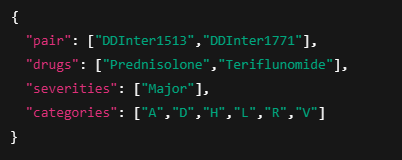